# 02: EDA

Description: Conducting exploratory data analysis ("EDA") on our combined DataFrame, plotting a number of weather-related features against mosquito abundance in order to get a better idea of the most important features, and transforming our data through feature engineering to ready it for preprocessing and model fitting.

## Table of Contents

1. [Mosquitos and Their Relationship to WNV](#1)
2. [Examining the Relationship between Weather and Mosquito Abundance](#2)
3. [Feature Engineering](#3)


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [18]:
df = pd.read_csv('../../data/final_dataframe.csv', index_col=0)

In [19]:
df.columns

Index(['Trap', 'Species', 'NumMosquitos', 'WnvPresent', 'Day_length', 'Tmax',
       'Tmin', 'Tavg', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Sunset',
       'Sunrise', 'Heat', 'Depart', 'DewPoint', 'WetBulb', 'Cool', 'CodeSum',
       'PrecipTotal', 'StnPressure', 'Latitude', 'Longitude', 'Month'],
      dtype='object')

<a name="1"></a>
## 1. Mosquitos and Their Relationship to WNV

Since mosquitos are the vector which transmits West Nile Virus to humans, we'll need to understand more about what makes up their population, and which types are most likely to carry the disease. 

### 1a. Counts of WNV Presence & Mosuito Species

A 1 indicates the presences of WNV, while a 0 indicates it is not present

In [20]:
df['WnvPresent'].value_counts()

0    8175
1     468
Name: WnvPresent, dtype: int64

In [21]:
df['Species'].value_counts()

CULEX PIPIENS/RESTUANS    3903
CULEX RESTUANS            2445
CULEX PIPIENS             1985
CULEX TERRITANS            220
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [22]:
df['Species'][df['WnvPresent'] == 1].value_counts()

CULEX PIPIENS/RESTUANS    229
CULEX PIPIENS             190
CULEX RESTUANS             49
Name: Species, dtype: int64

In [23]:
df['Species'].value_counts().sum(), 4469 + 2672 + 2239

(8643, 9380)

#### Analysis:

The combination of Culex Restuans and Pipiens make up roughly 96% of the total mosquito population and 100% of the WNV observations. 

- While there is a roughly equivelent amount of pure Restuans and Pipiens located in traps, there is a large discrepancy between the percentage of pure Pipiens observed with WNV (8%) and percentage of pure Restuans with WNV (1.7%). 
  - Given that, it's likely that within the 262 WNV observations within the duel Pipiens/Restuans, the majority of those observations are coming from Culex Pipiens

### 1b. Pulling in Outside Data on Mosquitos

Now that we have total mosquito figures which make up our training set, we're bringing in some outside information to help better shape our knowledge of mosquitos, and which species may be more likely to carry WNV:

"Culex" *from Wikipedia*: 
> Culex is a genus of mosquitoes, several species of which serve as vectors of one or more important diseases of birds, humans, and other animals. The diseases they vector include arbovirus infections such as **West Nile Virus**, Japanese encephalitis, or St. Louis encephalitis, but also filariasis and avian malaria. They occur worldwide except for the extreme northern parts of the temperate zone, and are the most common form of mosquito encountered in some major US cities such as Los Angeles. 

Species Bionomics *from [WRBU](http://www.wrbu.org/index.html)*

- **CULEX RESTUANS**: The larvae are found in a wide variety of aquatic habitats, such as ditches, pools in streams, woodland pools, and artificial containers. The females are regarded as troublesome biters by some observers, although others say that they rarely bite man. (Carpenter and LaCasse 1955:290)
- **CULEX PIPIENS**:  Larvae are found in numerous and variable breeding places ranging from highly polluted cesspits to clear water pools and containers. This species usually breeds in stagnant water in either shaded or unshaded situations. Females readily attack man both indoors and outdoors (Harbach 1988).
  - Medical Importance:  *It has been found naturally infected with Sindbis virus and West Nile viruses in Israel, West Nile and Rift Valley Fever in Egypt, and is a primary vector of periodic Bancroftian filariasis (Harbach 1988).*
- **CULEX TARSALIS**: The larvae are found in clear or foul water in a variety of habitats including ditches, irrigation systems, ground pools, marshes, pools in stream beds, rain barrels, hoofprints, and ornamental pools. Foul water in corrals and around slaughter yards appear to be favorite larval habitats in many localities. Cx. tarsalis are biters, attacking at dusk and after dark, and readily entering dwellings for blood meals. Domestic and wild birds seem to be the preferred hosts. and man, cows, and horses are generally incidental hosts. (Carpenter and LaCasse 1955:296)
- **CULEX ERRATICUS**: The larvae have been found in semipermanent and permanent pools including ditches, floodwater areas, grassy pools, streams, and occasionally in bilge water of boats and other artificial collections of water. (Carpenter and LaCasse 1955:315305)

This information confirms our prior. Pipiens are the vectors to look out for. 

Let's take a look at the population of mosquitos, and how they're spread over the course WNV season.

#### `NumMosquitos` Over Time (All Years Combined)

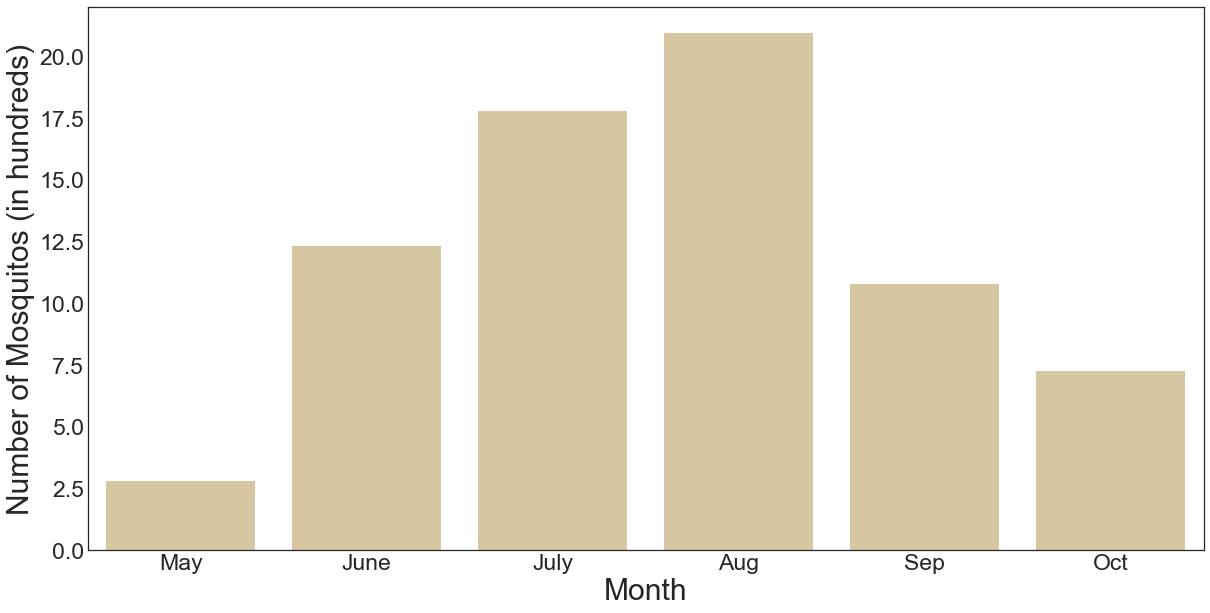

In [44]:
plt.figure(figsize=(20,10))
sns.barplot(x=df['Month'], 
            y=df['NumMosquitos'], 
           # hue=df['WnvPresent'], 
            dodge=True, 
            color='#dfca99',
#             palette='BrBG', 
            ci=None)
plt.xlabel('Month', size=30)
plt.xticks([0, 1, 2, 3, 4, 5],['May', 'June', 'July', 'Aug', 'Sep', 'Oct'], size=23)
plt.ylabel('Number of Mosquitos (in hundreds)', size=30)
plt.yticks(size=23)
# legend = plt.legend(['No', 'Yes'], title='WNV Present', fontsize=20)
plt.setp(legend.get_title(),fontsize=20)
plt.savefig('../../images/num_mosquitos.png')

In [26]:
dfWNV = df[df['WnvPresent'] == 1].groupby(['Species', 'WnvPresent'])[['NumMosquitos']].count().reset_index()
dfWNV0 = df[df['WnvPresent'] == 0].groupby(['Species', 'WnvPresent'])[['NumMosquitos']].count().reset_index()

Viewing the newly created dataframe

In [27]:
dfWNV

,Species,WnvPresent,NumMosquitos
0,CULEX PIPIENS,1,190
1,CULEX PIPIENS/RESTUANS,1,229
2,CULEX RESTUANS,1,49


Appending the species that can't carry WNV to the dataframe where WNV is present so that the two dataframe's have the same shape

In [28]:
dfWNV = dfWNV.append({'Species': 'CULEX ERRATICUS', 'WnvPresent': 0, 'NumMosquitos': 0}, ignore_index=True)
dfWNV = dfWNV.append({'Species': 'CULEX SALINARIUS', 'WnvPresent': 0, 'NumMosquitos': 0}, ignore_index=True)
dfWNV = dfWNV.append({'Species': 'CULEX TARSALIS', 'WnvPresent': 0, 'NumMosquitos': 0}, ignore_index=True)
dfWNV = dfWNV.append({'Species': 'CULEX TERRITANS', 'WnvPresent': 0, 'NumMosquitos': 0}, ignore_index=True)
dfWNV

,Species,WnvPresent,NumMosquitos
0,CULEX PIPIENS,1,190
1,CULEX PIPIENS/RESTUANS,1,229
2,CULEX RESTUANS,1,49
3,CULEX ERRATICUS,0,0
4,CULEX SALINARIUS,0,0
5,CULEX TARSALIS,0,0
6,CULEX TERRITANS,0,0


Inspecting the dataframe

In [29]:
dfWNV0

,Species,WnvPresent,NumMosquitos
0,CULEX ERRATICUS,0,1
1,CULEX PIPIENS,0,1795
2,CULEX PIPIENS/RESTUANS,0,3674
3,CULEX RESTUANS,0,2396
4,CULEX SALINARIUS,0,83
5,CULEX TARSALIS,0,6
6,CULEX TERRITANS,0,220


#### Plotting Mosquito Abundances with WNV vs. Without

In [30]:
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette('BrBG'))

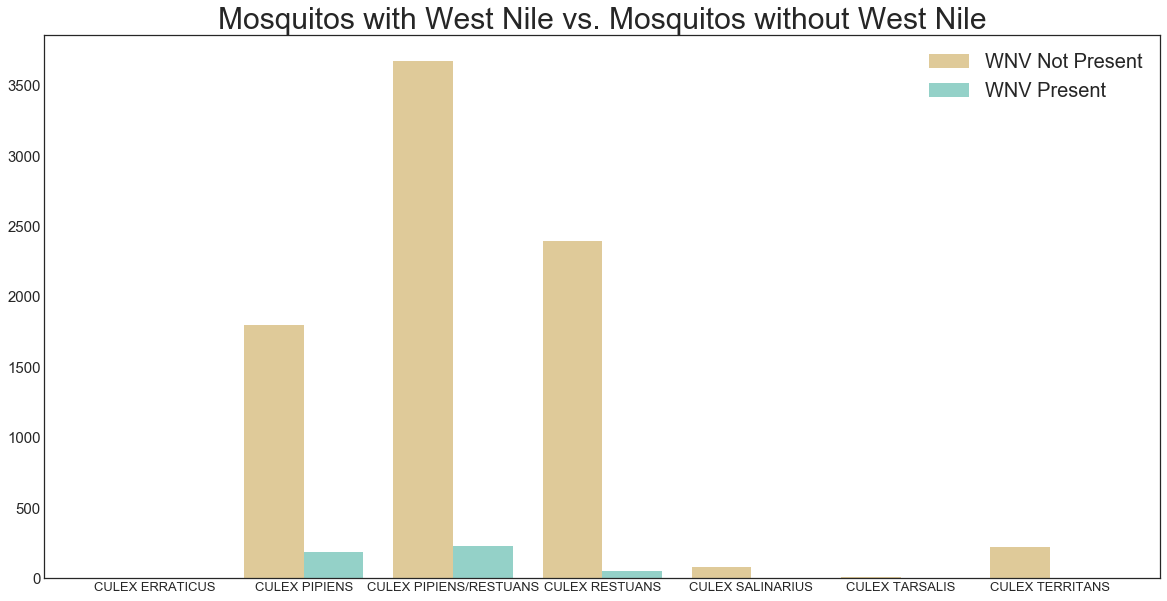

In [38]:
import matplotlib.style as style
style.use('seaborn-white')
fig, ax = plt.figure(figsize=(20,10)), plt.gca()
locs, labels = plt.xticks(fontsize=13)
plt.yticks(fontsize=15)
plt.setp(labels, rotation=0)
plt.title("Mosquitos with West Nile vs. Mosquitos without West Nile", fontsize=30)
plt.bar(dfWNV0['Species'], dfWNV0['NumMosquitos'], align='edge', width=-.4, color = "#dfca99")
plt.bar(dfWNV['Species'], dfWNV['NumMosquitos'], align='edge', width=.4, color = "#94d1c8")
plt.legend(labels=['WNV Not Present','WNV Present'], fontsize=20)
# plt.savefig('../../images/mosquitos_wnv.png')

<a name="2"></a>
## 2. Examining the Relationship between Weather and Mosquito Abundance

Coming into this study, we had a number of priors that influenced our perceptions of how weather would affect mosquito abundance, and therefore proliferation of WNV:

- Precipitation occurring several days prior to when an adult female mosquitos lay eggs increases the likelihood of successful hatches, and therefore more mosquitos
- Mosquito population growth is linked to the temperature, wherein the hotter it is, the easier it is for mosquitos to survive

### 2a. Ask the Experts

Before beginning this study, we encountered a number of pieces of prior research. The paper that most stood out to us, by *Karin Lieb, Katharina Buggar, and Franz Rubel*, represented a point of inspiration when it came to measuring weather conditions against mosquito abundance. Our reasoning was that the study was held in the Chicago area, and covered some of the same years which we have data for as well.

Given this, we've decided to algn our lags with the figures that *Lieb, et al* touted within the abstract. While, our rolling mean of 3 days ensures our model isn't affected by sudden spikes, and maintains a smoother distribution of values.

|Feature|Rolling Mean|Shifted Value|
|---|---|---|
|Day Length|3|28|
|Temp Avg|3|14|
|Temp Max|3|14|
|Temp Min|3|14|
|Departure|3|14|
|Heat|3|14|
|Cool|1|14|
|Result Speed|1|21|
|Result Dir|1|21|
|Wet Bulb|3|14|



*To Note: To ensure a thorough review of the all features available, we also conducted a search of all features through a function we defined to determine which lag time contributed the most to mosquito abundance. You can find this data in Appendix ii*

<a name="3"></a>
## 3. Feature Engineering

**Adding Consistent Shifted and Rolling Means in line with `Lebl, et al`**

In [51]:
df['Day_length_shift'] = df['Day_length'].rolling(3).mean().shift(28)
df.loc[0:29, 'Day_length_shift'] = df.loc[30, 'Day_length_shift']

df['Tavg_shift'] = df['Tavg'].rolling(3).mean().shift(14)
df.loc[0:15, 'Tavg_shift'] = df.loc[16, 'Tavg_shift']

df['Heat_shift'] = df['Heat'].rolling(3).mean().shift(14)
df.loc[0:15, 'Heat_shift'] = df.loc[16, 'Heat_shift']

df['Cool_shift'] = df['Cool'].rolling(1).mean().shift(14)
df.loc[0:15, 'Cool_shift'] = df.loc[16, 'Cool_shift']

df['Tmax_shift'] = df['Tmax'].rolling(3).mean().shift(14)
df.loc[0:15, 'Tmax_shift'] = df.loc[16, 'Tmax_shift']

df['Tmin_shift'] = df['Tmin'].rolling(3).mean().shift(14)
df.loc[0:15, 'Tmin_shift'] = df.loc[16, 'Tmin_shift']

df['Depart_shift'] = df['Depart'].rolling(3).mean().shift(14)
df.loc[0:15, 'Depart_shift'] = df.loc[16, 'Depart_shift']

df['ResultSpeed_shift'] = df['ResultSpeed'].rolling(1).mean().shift(21)
df.loc[0:20, 'ResultSpeed_shift'] = df.loc[21, 'ResultSpeed_shift']

df['ResultDir_shift'] = df['ResultDir'].rolling(1).mean().shift(21)
df.loc[0:20, 'ResultDir_shift'] = df.loc[21, 'ResultDir_shift']

df['WetBulb_shift'] = df['WetBulb'].rolling(3).mean().shift(14)
df.loc[0:15, 'WetBulb_shift'] = df.loc[16 , 'WetBulb_shift']

#### Plotting Shifted Day Length Against Mosquito Abundance

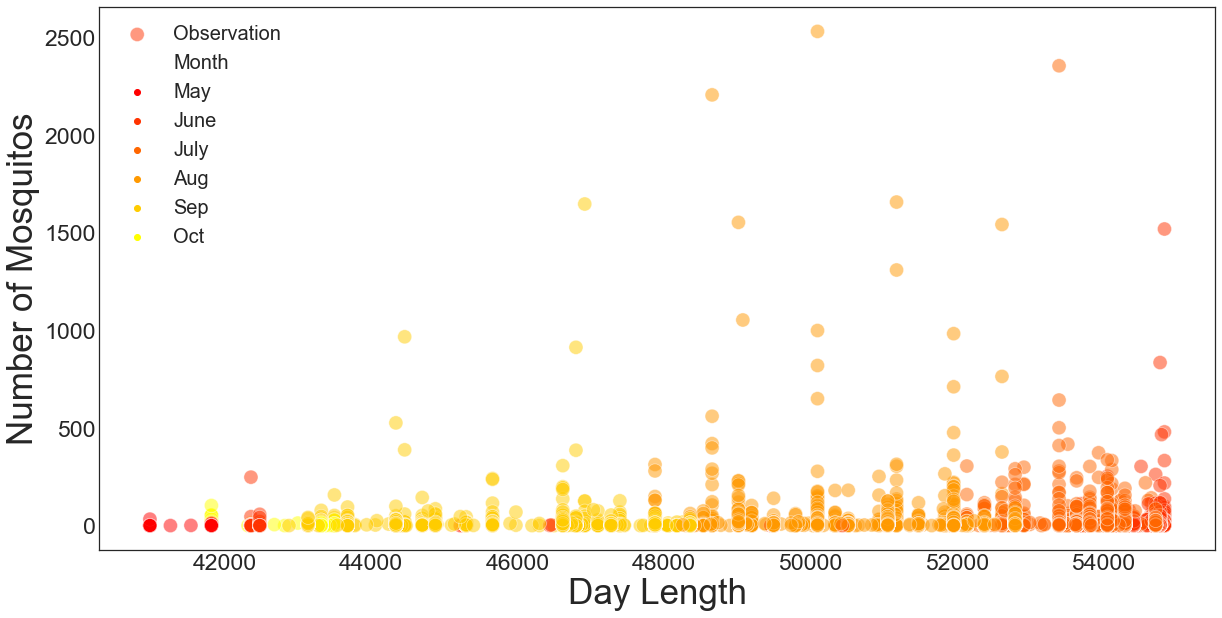

In [55]:
plt.figure(figsize=(20,10))
sns.scatterplot(df['Day_length'].rolling(3).mean().shift(28), 
                df['NumMosquitos'], 
                hue=df['Month'], 
                marker='.', 
                palette='autumn', 
                s=800, 
                legend="full",
               alpha=.5)
plt.xlabel('Day Length', size=35)
plt.xticks(size=23)
plt.ylabel('Number of Mosquitos', size=35)
plt.yticks(size=23)
plt.legend(labels=['Observation', 'Month', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct'], fontsize=20)
# plt.savefig('../../images/shifted_daylength.png');

#### Plotting Shifted Temperature Against Mosquito Abundance

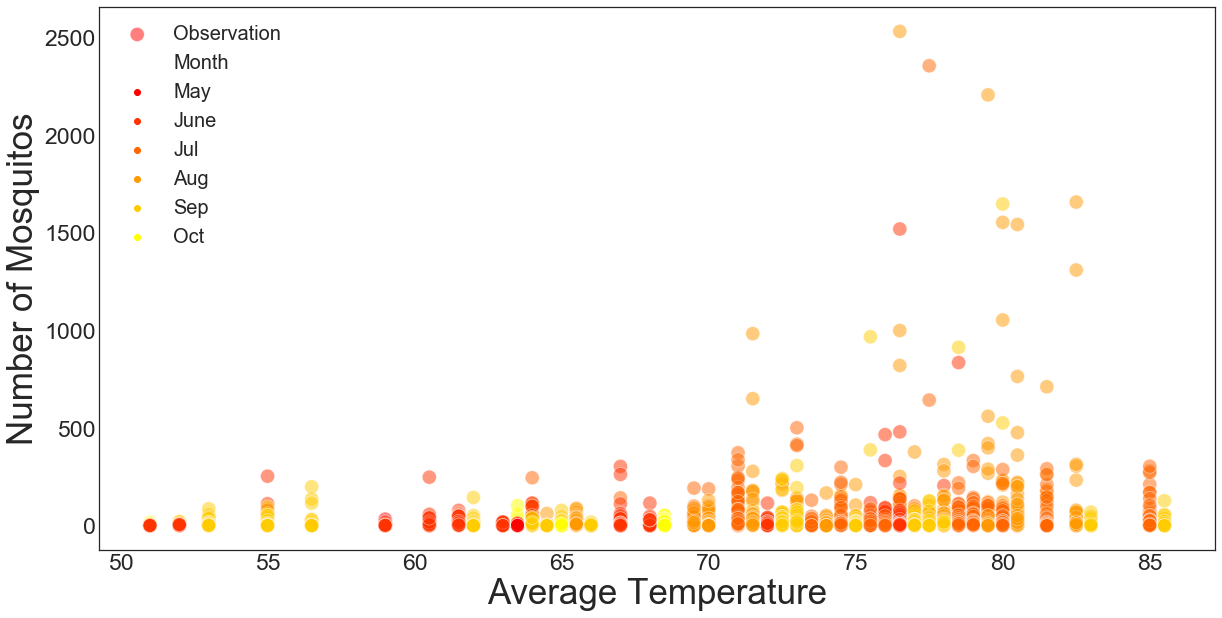

In [57]:
plt.figure(figsize=(20,10))
sns.scatterplot(df['Tavg'].rolling(1).mean().shift(7), 
                df['NumMosquitos'],
                alpha = .5, 
                hue=df['Month'], 
                marker='.', 
                s=800 ,
                palette='autumn', 
                legend='full');
plt.xlabel('Average Temperature', size=35)
plt.xticks(size=23)
plt.ylabel('Number of Mosquitos', size=35)
plt.yticks(size=23)
plt.legend(labels=['Observation','Month','May', 'June', 'Jul', 'Aug', 'Sep', 'Oct'], fontsize=20);
# plt.savefig('../../images/shifted_tavg.png')

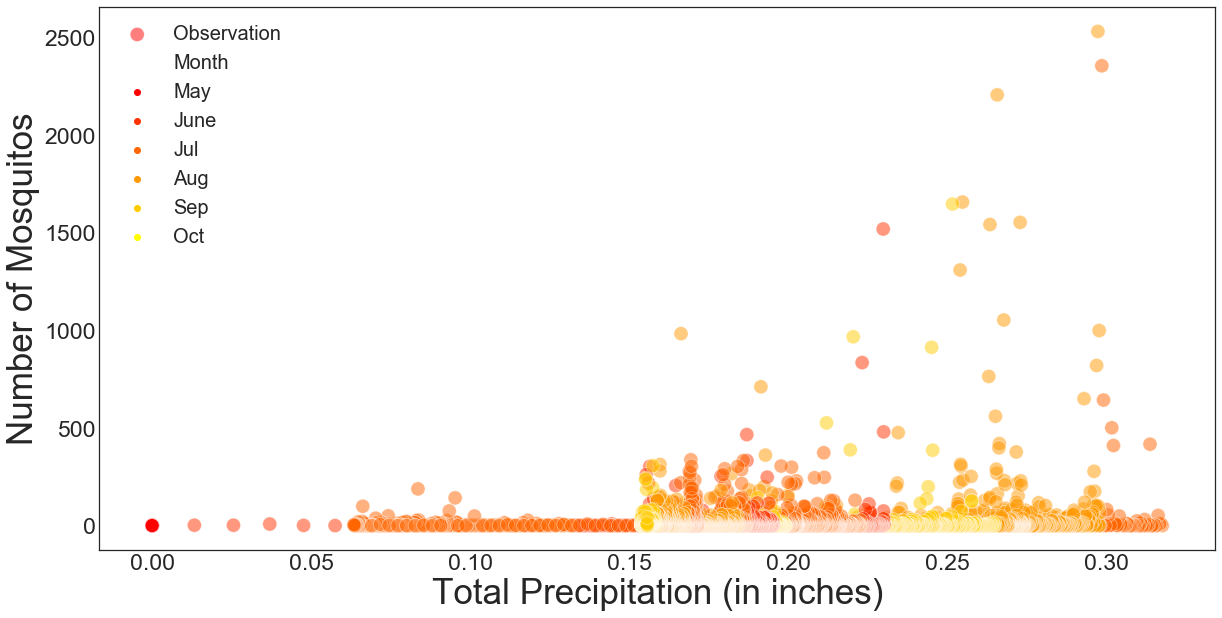

In [60]:
plt.figure(figsize=(20,10))
sns.scatterplot(df['PrecipTotal'].expanding().mean(), 
                df['NumMosquitos'], 
                palette='autumn', 
                hue=df['Month'], 
                marker='.', 
                s=800, 
                alpha=.5, 
                legend='full')
plt.xlabel('Total Precipitation (in inches)', size=35)
plt.xticks(size=23)
plt.ylabel('Number of Mosquitos', size=35)
plt.yticks(size=23)
plt.legend(labels=['Observation','Month','May', 'June', 'Jul', 'Aug', 'Sep', 'Oct'], fontsize=20, loc=2);
# plt.savefig('../../images/precip.png');

#### Plotting Shifted Wind Speed Against Mosquito Abundance

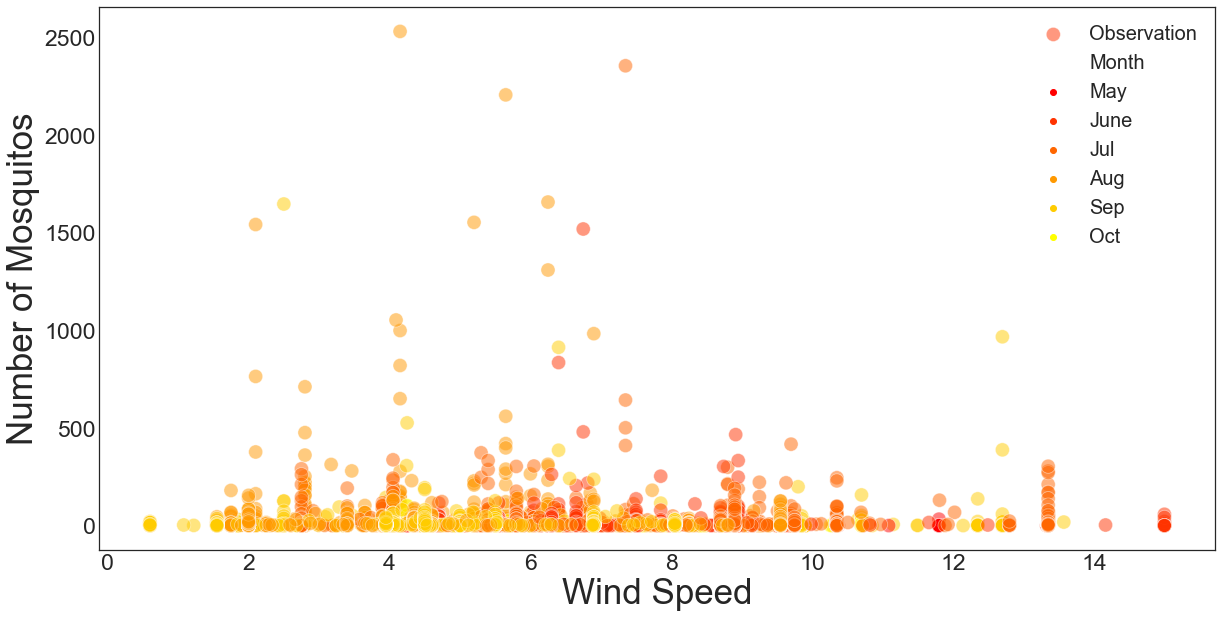

In [59]:
plt.figure(figsize=(20,10))
sns.scatterplot(df['ResultSpeed'].rolling(7).mean().shift(28), 
                df['NumMosquitos'], 
                hue=df['Month'], 
                palette='autumn', 
                marker='.', 
                s=800, 
                alpha=.5, 
                legend='full')
plt.xlabel('Wind Speed', size=35)
plt.xticks(size=23)
plt.ylabel('Number of Mosquitos', size=35)
plt.yticks(size=23)
plt.legend(labels=['Observation','Month','May', 'June', 'Jul', 'Aug', 'Sep', 'Oct'], fontsize=20);
# plt.savefig('../../images/shifted_wind.png')

#### Plotting Month vs. Max Temperature Shifted (shifted by 1 week)

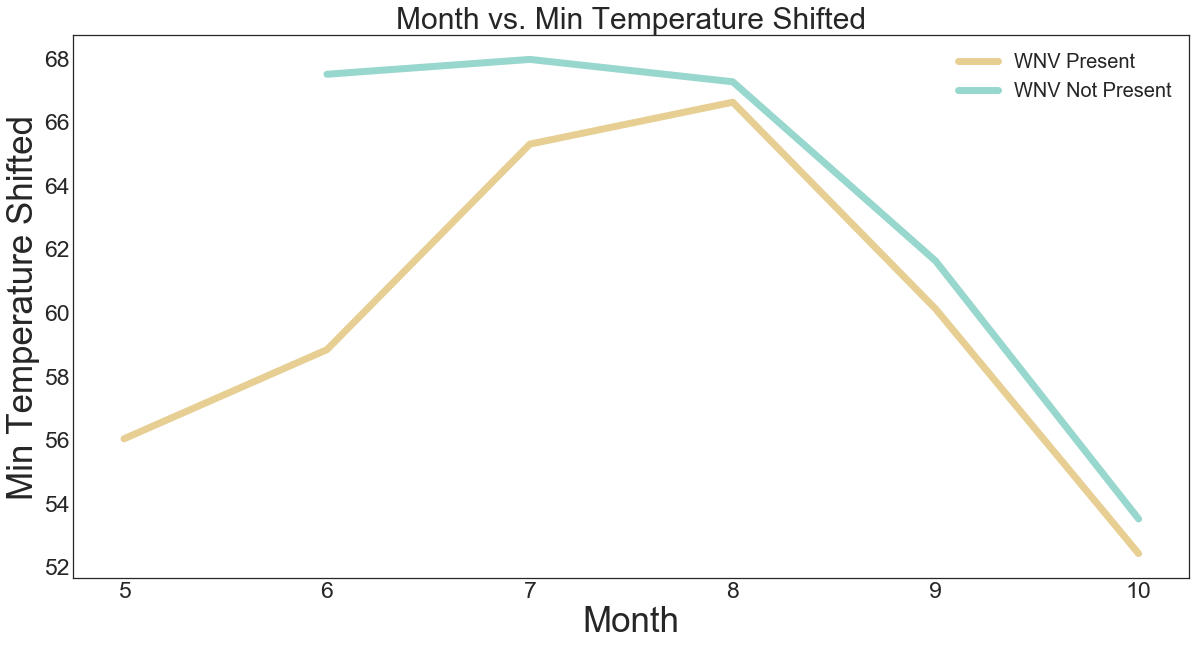

In [61]:
plt.figure(figsize=(20,10))
sns.lineplot(x=df['Month'], 
             y=df['Tmin_shift'], 
             hue = df['WnvPresent'], 
             palette = 'BrBG', 
             ci=None, 
             lw=7)
plt.xlabel('Month', size=35)
plt.xticks(size=23)
plt.ylabel('Min Temperature Shifted', size=35)
plt.yticks(size=23)
plt.title("Month vs. Min Temperature Shifted", fontsize=30)
plt.legend(labels=['WNV Present','WNV Not Present'], fontsize=20);
# plt.savefig('../../images/max_temp.png')

#### Plotting Shifted WetBulb Mean Against Mosquito Abundance

**Checking Resultant DataFrame**

In [20]:
df.columns

Index(['Trap', 'Species', 'NumMosquitos', 'WnvPresent', 'Day_length', 'Tmax',
       'Tmin', 'Tavg', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Sunset',
       'Sunrise', 'Heat', 'Depart', 'DewPoint', 'WetBulb', 'Cool', 'CodeSum',
       'PrecipTotal', 'StnPressure', 'Latitude', 'Longitude', 'Month',
       'Day_length_shift', 'Tavg_shift', 'Heat_shift', 'Cool_shift',
       'Tmax_shift', 'Tmin_shift', 'Depart_shift', 'ResultSpeed_shift',
       'ResultDir_shift', 'WetBulb_shift'],
      dtype='object')

In [21]:
df.shape

(8643, 34)

In [22]:
df.head()

,Trap,Species,NumMosquitos,WnvPresent,Day_length,Tmax,Tmin,Tavg,ResultSpeed,ResultDir,...,Day_length_shift,Tavg_shift,Heat_shift,Cool_shift,Tmax_shift,Tmin_shift,Depart_shift,ResultSpeed_shift,ResultDir_shift,WetBulb_shift
0,T002,CULEX PIPIENS/RESTUANS,1,0,53760,88.0,62.5,75.5,5.8,17.0,...,53760.0,75.5,0.0,10.5,88.0,62.5,10.0,5.8,17.0,65.5
1,T002,CULEX RESTUANS,1,0,53760,88.0,62.5,75.5,5.8,17.0,...,53760.0,75.5,0.0,10.5,88.0,62.5,10.0,5.8,17.0,65.5
2,T007,CULEX RESTUANS,1,0,53760,88.0,62.5,75.5,5.8,17.0,...,53760.0,75.5,0.0,10.5,88.0,62.5,10.0,5.8,17.0,65.5
3,T015,CULEX PIPIENS/RESTUANS,1,0,53760,88.0,62.5,75.5,5.8,17.0,...,53760.0,75.5,0.0,10.5,88.0,62.5,10.0,5.8,17.0,65.5
4,T015,CULEX RESTUANS,4,0,53760,88.0,62.5,75.5,5.8,17.0,...,53760.0,75.5,0.0,10.5,88.0,62.5,10.0,5.8,17.0,65.5


In [23]:
df.columns

Index(['Trap', 'Species', 'NumMosquitos', 'WnvPresent', 'Day_length', 'Tmax',
       'Tmin', 'Tavg', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Sunset',
       'Sunrise', 'Heat', 'Depart', 'DewPoint', 'WetBulb', 'Cool', 'CodeSum',
       'PrecipTotal', 'StnPressure', 'Latitude', 'Longitude', 'Month',
       'Day_length_shift', 'Tavg_shift', 'Heat_shift', 'Cool_shift',
       'Tmax_shift', 'Tmin_shift', 'Depart_shift', 'ResultSpeed_shift',
       'ResultDir_shift', 'WetBulb_shift'],
      dtype='object')

In [24]:
# df.to_csv('../data/final_dataframe_features.csv')

### Next notebook: `03_preprocessing`